# Awkward *Quick, Draw!* GAN with No Warning

In this notebook, we use an awkward workaround to avoid the unnecessary Keras warning produced by our [*Quick, Draw!* GAN](https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/generative_adversarial_network.ipynb).

#### Load dependencies

In [1]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Lambda
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new!
from keras import backend as K

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Load data
NumPy bitmap files are [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) -- pick your own drawing category -- you don't have to pick *apples* :)

In [2]:
input_images = "../quickdraw_data/apple.npy"

In [3]:
data = np.load(input_images) # 28x28 (sound familiar?) grayscale bitmap in numpy .npy format; images are centered

In [4]:
# data.shape

In [5]:
# data[4242]

In [6]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]
# data.shape

In [7]:
# data[4242]

In [8]:
# plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Create discriminator network

In [9]:
def build_discriminator(depth=64, p=0.4):

    # Define inputs
    image = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    prediction = Dense(1, activation='sigmoid', name='prediction')(conv4)
    
    # Model definition
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [10]:
discriminator = build_discriminator()

In [12]:
# discriminator.summary()

In [13]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['binary_accuracy'])

#### Build an untrainable discriminator

To create a workaround that avoids the following (unnecessary!) warning being thrown by recent versions of Keras...

`Discrepancy between trainable weights and collected trainable weights, did you set model.trainable without calling model.compile after ?`

...we awkwardly build a second, discriminator (`discriminator_`) for use in the adversarial model. This model is identical to the first discriminator (`discriminator`) except that it's unequivocally _untrainable_ (it isn't even compiled!). We copy the weights from the trainable `discriminator` model into the untrainable `discriminator_` model each time we want to use it. Thus, the adversarial model gets a fresh _copy_ of the discriminator's parameters in each round of training.

In [ ]:
# Build an identical discriminator: 
discriminator_ = build_discriminator()

# Set the model so that its parameters are frozen: 
discriminator_.trainable = False

In [27]:
# Function to copy the weights from the trainable discriminator to the frozen discriminator_
def copy_weights(source, target):
    for i, layer in enumerate(source.layers):
        target.layers[i].set_weights(source.layers[i].get_weights())

#### Create generator network

In [14]:
z_dimensions = 32

In [15]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [16]:
generator = build_generator()

In [17]:
# generator.compile(loss='binary_crossentropy', 
#                           optimizer=RMSprop(lr=0.0004, 
#                                             decay=3e-8, 
#                                             clipvalue=1.0), 
#                           metrics=['accuracy'])

In [18]:
# generator.summary()

#### Create adversarial network

In [22]:
def build_adversarial():
          
    # Define input
    z = Input(shape=(z_dimensions,))
    
    # Generate image from noise
    img = generator(z)
    
    # Make prediction
    pred = discriminator_(img)
       
    # Build model
    model = Model(inputs=z, outputs=pred)
    
    return model

In [23]:
adversarial_model = build_adversarial()

In [24]:
# adversarial_model.summary()

In [25]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### Train!

In [28]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        #######################
        # train discriminator:#
        #######################
        
        # sample real images: 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator:
        # Added noisy labels, as per here: https://link.medium.com/yUuw4Y33PX
        # Note: disciminator accuracy will always be zero now...
        y = np.ones([2*batch,1]) - np.random.uniform(0,0.1,[2*batch,1])
        y[batch:,:] = 0
        y[batch:,:] += np.random.uniform(0,0.1,[batch,1])
        
        # do training
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        #########################
        # train adversarial net:#
        #########################
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # Copy weights to frozen discriminator
        copy_weights(discriminator, discriminator_)
        
        # do training
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        #########################
        #     Print results     #
        #########################
        
        # periodically print progress & fake images: 
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

Epoch #19
19: [D loss: 0.453371, acc: 0.000000]  [A loss: 4.435126, acc: 0.091694]


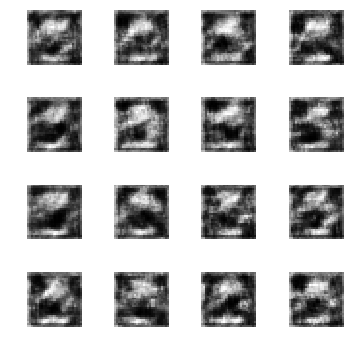

Epoch #39
39: [D loss: 0.334127, acc: 0.000000]  [A loss: 3.056854, acc: 0.077925]


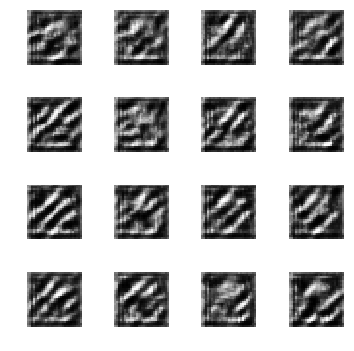

Epoch #59
59: [D loss: 0.303718, acc: 0.000000]  [A loss: 2.744749, acc: 0.060249]


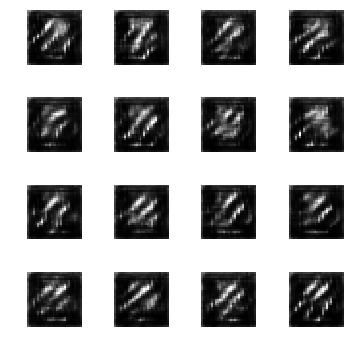

Epoch #79
79: [D loss: 0.289979, acc: 0.000000]  [A loss: 2.701959, acc: 0.045293]


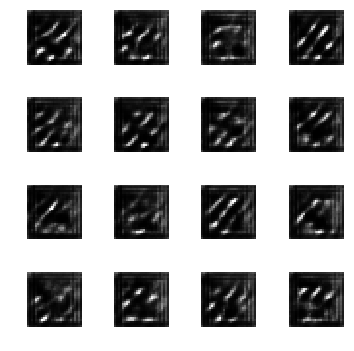

Epoch #99
99: [D loss: 0.278587, acc: 0.000000]  [A loss: 2.696242, acc: 0.036932]


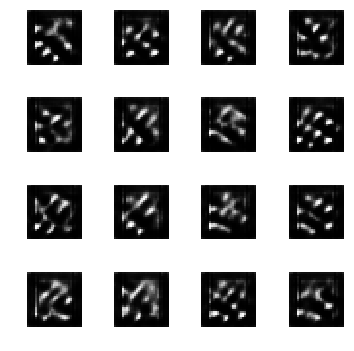

Epoch #119
119: [D loss: 0.274848, acc: 0.000000]  [A loss: 2.771479, acc: 0.031578]


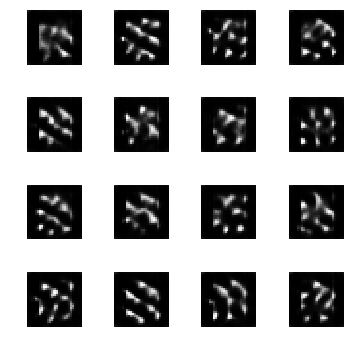

Epoch #139
139: [D loss: 0.268333, acc: 0.000000]  [A loss: 2.824527, acc: 0.027147]


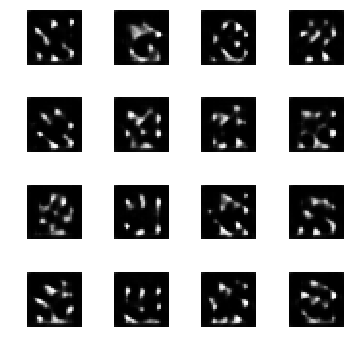

Epoch #159
159: [D loss: 0.263651, acc: 0.000000]  [A loss: 2.881071, acc: 0.023831]


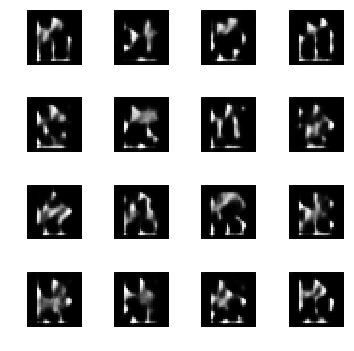

Epoch #179
179: [D loss: 0.259093, acc: 0.000000]  [A loss: 2.930577, acc: 0.021430]


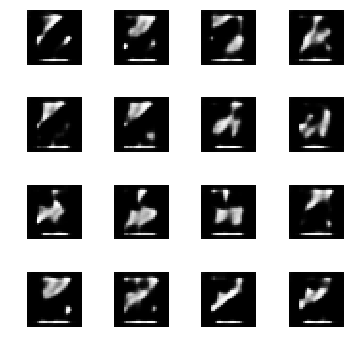

Epoch #199
199: [D loss: 0.255968, acc: 0.000000]  [A loss: 2.954933, acc: 0.019394]


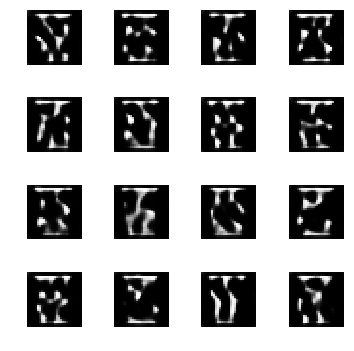

Epoch #219
219: [D loss: 0.256435, acc: 0.000000]  [A loss: 2.946853, acc: 0.018086]


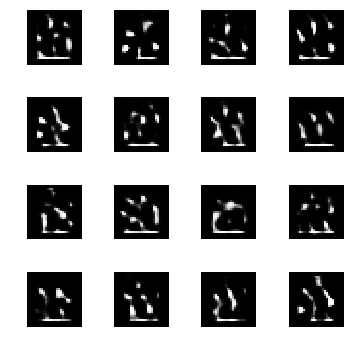

Epoch #239
239: [D loss: 0.257250, acc: 0.000000]  [A loss: 2.992618, acc: 0.017325]


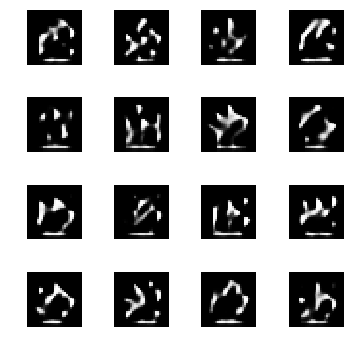

Epoch #259
259: [D loss: 0.258281, acc: 0.000000]  [A loss: 2.987003, acc: 0.016590]


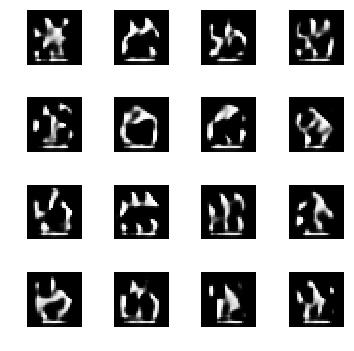

Epoch #279
279: [D loss: 0.260375, acc: 0.000000]  [A loss: 2.975628, acc: 0.016885]


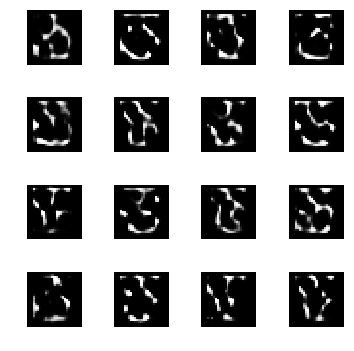

Epoch #299
299: [D loss: 0.265149, acc: 0.000000]  [A loss: 2.952573, acc: 0.017271]


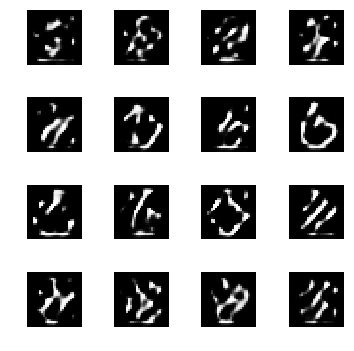

Epoch #319
319: [D loss: 0.268889, acc: 0.000000]  [A loss: 2.951979, acc: 0.017682]


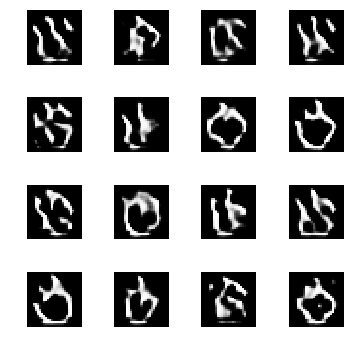

Epoch #339
339: [D loss: 0.273469, acc: 0.000000]  [A loss: 2.905721, acc: 0.021847]


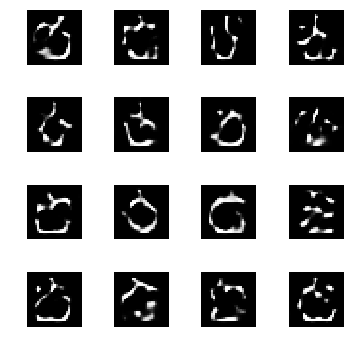

Epoch #359
359: [D loss: 0.277721, acc: 0.000000]  [A loss: 2.900040, acc: 0.022785]


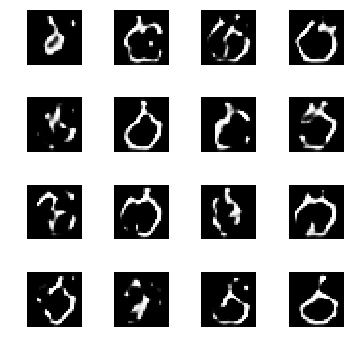

Epoch #379
379: [D loss: 0.284788, acc: 0.000000]  [A loss: 2.860257, acc: 0.025561]


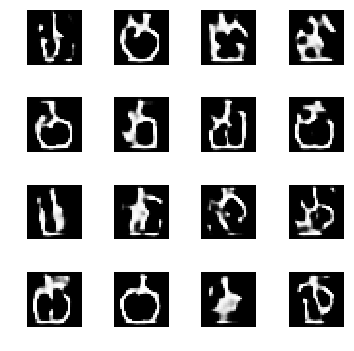

Epoch #399
399: [D loss: 0.293227, acc: 0.000000]  [A loss: 2.785305, acc: 0.037104]


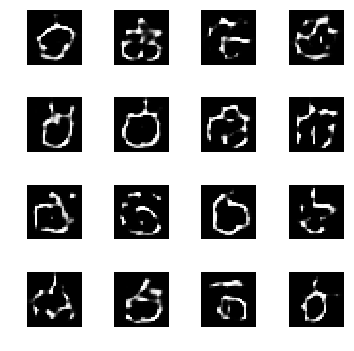

Epoch #419
419: [D loss: 0.301166, acc: 0.000000]  [A loss: 2.744282, acc: 0.040685]


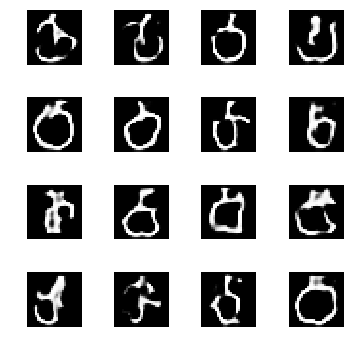

Epoch #439
439: [D loss: 0.309363, acc: 0.000000]  [A loss: 2.702955, acc: 0.044063]


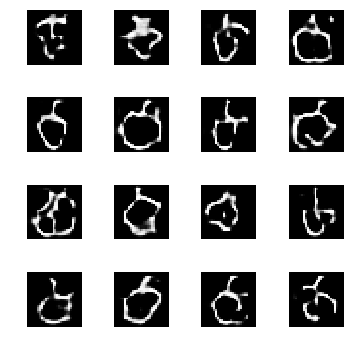

Epoch #459
459: [D loss: 0.317585, acc: 0.000000]  [A loss: 2.654657, acc: 0.048373]


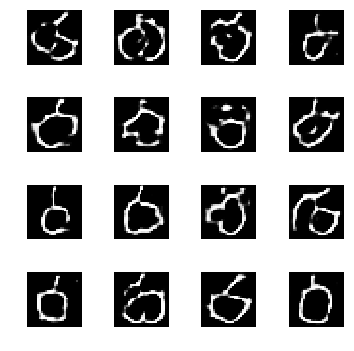

Epoch #479
479: [D loss: 0.326103, acc: 0.000000]  [A loss: 2.605261, acc: 0.052893]


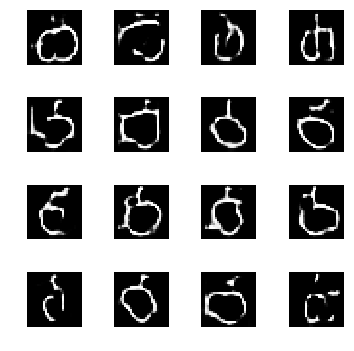

Epoch #499
499: [D loss: 0.333987, acc: 0.000000]  [A loss: 2.563679, acc: 0.055517]


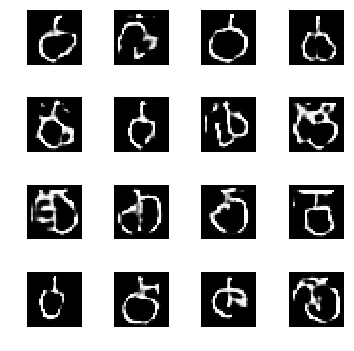

Epoch #519
519: [D loss: 0.340004, acc: 0.000000]  [A loss: 2.527370, acc: 0.058391]


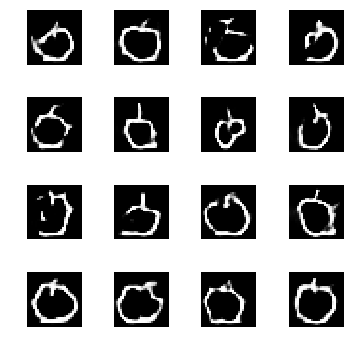

Epoch #539
539: [D loss: 0.344501, acc: 0.000000]  [A loss: 2.499653, acc: 0.060123]


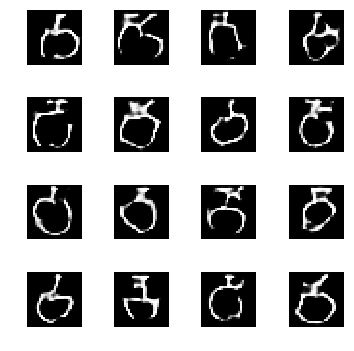

Epoch #559
559: [D loss: 0.349529, acc: 0.000000]  [A loss: 2.472035, acc: 0.061801]


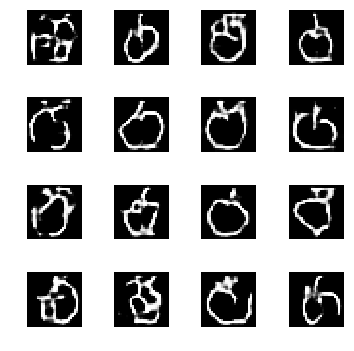

Epoch #579
579: [D loss: 0.353390, acc: 0.000000]  [A loss: 2.443890, acc: 0.064483]


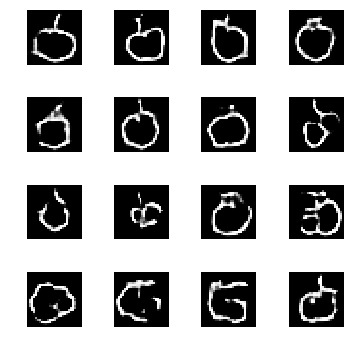

Epoch #599
599: [D loss: 0.356943, acc: 0.000000]  [A loss: 2.424267, acc: 0.065604]


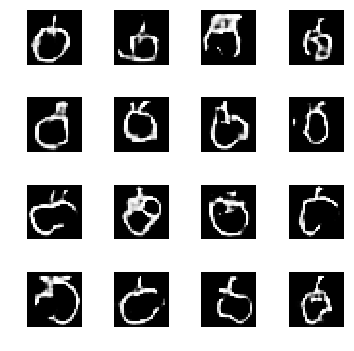

Epoch #619
619: [D loss: 0.359194, acc: 0.000000]  [A loss: 2.409222, acc: 0.067107]


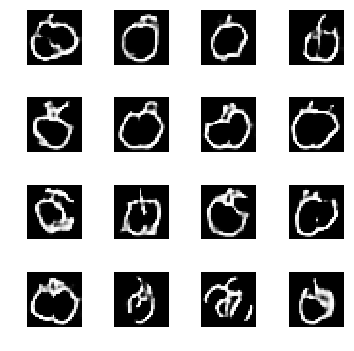

Epoch #639
639: [D loss: 0.361438, acc: 0.000000]  [A loss: 2.397546, acc: 0.067818]


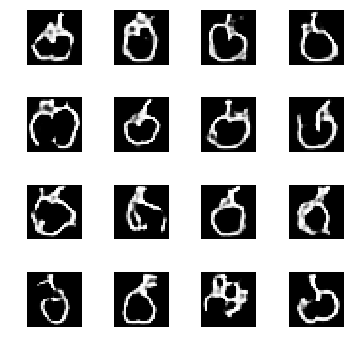

Epoch #659
659: [D loss: 0.363179, acc: 0.000000]  [A loss: 2.384826, acc: 0.068949]


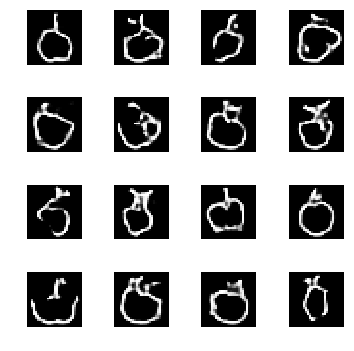

Epoch #679
679: [D loss: 0.364286, acc: 0.000000]  [A loss: 2.378263, acc: 0.069450]


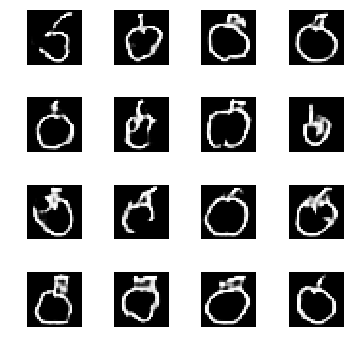

Epoch #699
699: [D loss: 0.365407, acc: 0.000000]  [A loss: 2.369480, acc: 0.070178]


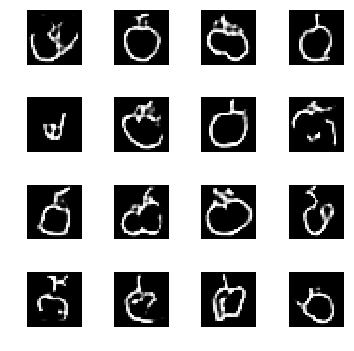

Epoch #719
719: [D loss: 0.366683, acc: 0.000000]  [A loss: 2.362403, acc: 0.070465]


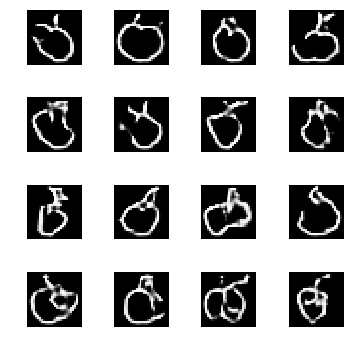

Epoch #739
739: [D loss: 0.367951, acc: 0.000000]  [A loss: 2.351689, acc: 0.071243]


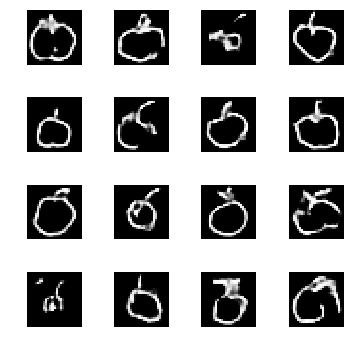

Epoch #759
759: [D loss: 0.368267, acc: 0.000000]  [A loss: 2.349952, acc: 0.071527]


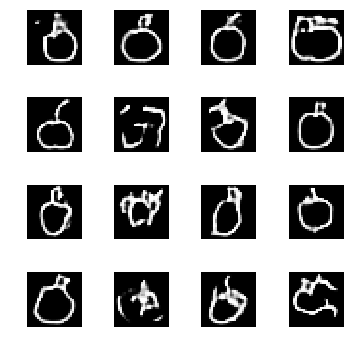

In [ ]:
a_metrics_complete, d_metrics_complete = train()

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")